In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

In [2]:
class WingOptimiser():
    def __init__(self):
        self.wing_offers = self.read_wing_table()
        self.n_wings = 5

    def read_wing_table(self):
        wing_table = pd.read_csv("wing_prices.csv")
        wing_json = json.loads(wing_table.to_json(orient="records"))
        return wing_json

    def define_model(self):
        self.solver = pywraplp.Solver.CreateSolver("SCIP")
        self.create_variables()
        self.create_objective()   
        self.create_constraints()   

    def create_variables(self):
        for dic in self.wing_offers:
            dic["variable"] = self.solver.IntVar(
                0, 
                self.solver.infinity(),
                f"Number of orders with offer {dic['amount']} wings"
            )
    def create_objective(self):
        if self.mode == "price":
            objective = [dic["price"]*dic["variable"] for dic in self.wing_offers]
        elif self.mode == "n_wings":
            objective = [dic["variable"] for dic in self.wing_offers]
        self.solver.Minimize(sum(objective))

    def create_constraints(self):
        self.solver.Add(
            sum([dic["amount"]*dic["variable"] for dic in self.wing_offers]) == self.n_wings
        )

        if self.mode == "n_wings":
            self.solver.Add(
                sum([dic["price"]*dic["variable"] for dic in self.wing_offers]) <= self.price
            )

    def format_solution(self):
        money_spent = 0
        election_dict = {}
        for dic in self.wing_offers:
            solution_value = dic["variable"].solution_value()
            if solution_value > 0:
                amount, price = dic["amount"], dic["price"]
                election_dict[amount] = solution_value
                # election_string += f"Offer {amount}. Get {int(solution_value)}"
                money_spent += solution_value * price
        return money_spent, election_dict

    def solve(self, n_wings=5):
        # 1. Optimise price
        self.n_wings, self.mode = n_wings, "price"
        self.define_model()
        self.solver.Solve()
        self.price, solution = self.format_solution()
        # 2. Optimise the number of offers we need to make
        self.mode = "n_wings"
        self.define_model()
        self.solver.Solve()
        return self.format_solution()

In [3]:
optimiser = WingOptimiser()

In [4]:
prices, solutions = [], []
n_wings_l = list(range(4, 200))
for n_wings in n_wings_l:
    price, solution = optimiser.solve(n_wings=n_wings)
    prices.append(price)
    solutions.append(solution)

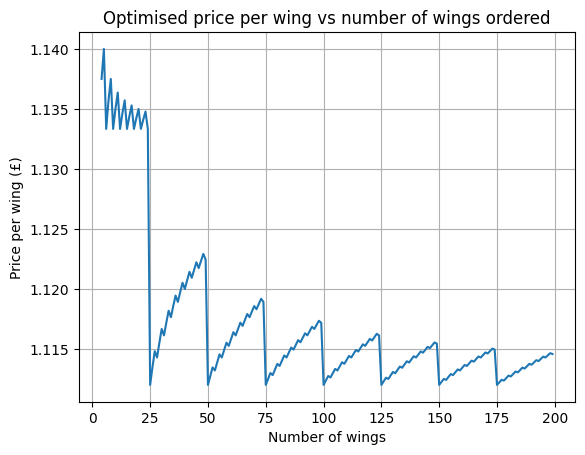

In [5]:
costs_per_wing = [x/y for x,y in zip(prices, n_wings_l)]
plt.plot(n_wings_l, costs_per_wing)
plt.xlabel("Number of wings")
plt.ylabel("Price per wing (£)")
plt.title("Optimised price per wing vs number of wings ordered")
plt.grid()
plt.show()

In [6]:
# get the minimum cost per wing, along with the number of wings
min_cost_per_wing = min(costs_per_wing)
print(f"Minimum cost per wing: £{min_cost_per_wing:.2f}")
wings_indexes_with_min_cost = np.where(np.array(costs_per_wing) == min_cost_per_wing)[0]
print(f"Number of wings with minimum cost per wing: {len(wings_indexes_with_min_cost)}")
wings_with_min_cost = n_wings_l[wings_indexes_with_min_cost[0]]
print(f"\nOnly wings with minimum cost per wing: {wings_with_min_cost}")
# get the solution for that number of wings
for wing_offer, number_of_offers in solutions[wings_indexes_with_min_cost[0]].items():
    print(f"- Offer {wing_offer} wings: {int(number_of_offers)} times")


Minimum cost per wing: £1.11
Number of wings with minimum cost per wing: 1

Only wings with minimum cost per wing: 175
- Offer 50 wings: 1 times
- Offer 125 wings: 1 times


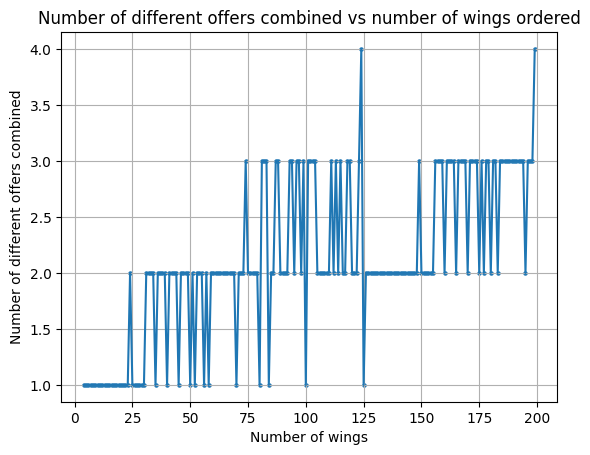

In [7]:
plt.plot(n_wings_l, [len(x.values()) for x in solutions])
# put dots
plt.scatter(n_wings_l, [len(x.values()) for x in solutions], s=5)

plt.xlabel("Number of wings")
plt.ylabel("Number of different offers combined")
plt.title("Number of different offers combined vs number of wings ordered")
plt.grid()
plt.show()